# Основные методы поиска оценок. Задача 3

__Ильичёв А.С., 693__

In [115]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### 1. Считаем данные.


In [116]:
df = pd.read_csv('Weibull.csv', names=['val'])

#### 2. Найдем логарифмическую функцию правдоподобия.

В качестве параметра $\theta$ выступает $\gamma$.

$$F(x) = 1 - e^{-x^\gamma}I(x>0)$$
$$p(x) = F'(x) = \gamma x^{\gamma - 1}e^{-x^\gamma}I(x>0)$$
$$f_{\theta}(x_1, \dots, x_n) = \gamma^n \left(\prod_{i=1}^n x_i\right)^{\gamma - 1} e^{-\sum_{i=1}^n x_i^\gamma}$$
$$L_{\theta}(x_1, \dots, x_n) = n\ln\gamma + (\gamma - 1)\sum_{i=1}^n\ln x_i - \sum_{i=1}^n x_i^\gamma$$

В силу монотонности логарифма для получения оценки  максимального правдоподобия достаточно найти $\underset{\theta}{\mathrm{argmax}}L_\theta(x_1, \dots, x_n)$. Получим задачу $$\underset{\theta}{\mathrm{argmax}} \left(n\ln\gamma + (\gamma - 1)\sum_{i=1}^n\ln x_i - \sum_{i=1}^n x_i^\gamma\right).$$

#### 3. Обработаем выборку.

In [117]:
df.head()

,val
0,0.00
1,0.01
2,0.11
3,1.79
4,0.03


In [118]:
len(df[df['val'] == 0])

400

Видим, что в выборке присутствуют нулевые значения, однако в функцию плотности могут входить отрицательные степени $x$. Поэтому заменим нули на значение, меньшее любого другого в выборке. Вообще говоря, в выборке больше $10\%$ нулей, поэтому итоговая оценка будет зависеть от того, каким мы выберем это значение. Тем не менее, из-за округления всего лишь до второго порядка мы не знаем, какие именно элементы были в исходном распределении, поэтому замена тут достаточно произвольна.

In [119]:
df['val'] = df['val'].replace(0.0, df[df['val'] > 0]['val'].min() / 100)

In [129]:
df.head()

,val
0,0.0001
1,0.0100
2,0.1100
3,1.7900
4,0.0300


In [130]:
df.describe()

,val
count,3652.000000
mean,2.858970
std,7.819182
min,0.000100
25%,0.050000
50%,0.465000
75%,2.262500
max,121.040000


#### 4. Оценим параметр сдвига методом максимального правдоподобия.

In [121]:
def calc_func(df, g):
    # считаем максимизируемую функцию
    return (len(df) * g + (g - 1) * np.sum(np.log(df['val'])) -
            np.sum(df['val'] ** g))
                    

Оценку производим по сетке в логарифмической шкале c шагом $10^{-3}$.

In [122]:
grid = np.linspace(-2, 2, 4 * 1000 + 1)

In [139]:
def find_max(df):
    vals = np.array([calc_func(df, 10 ** lg) for lg in grid])
    plt.figure(figsize=(10,5))
    plt.plot(grid, vals)
    max_i = np.argmax(vals)
    plt.scatter([grid[max_i]], [vals[max_i]], c='red')
    plt.xlabel(r'$\log_{10}(\gamma)$')
    plt.ylim(-vals[max_i] * 5, vals[max_i] * 1.2)
    plt.show()
    print('max = ', vals[max_i])
    print('log10(gamma) = ', grid[max_i])
    print('Оценка максимального правдоподобия: gamma = ', 10 ** grid[max_i])
    

a) По первым четырем годам (т.к. всего 3652 элемента, среди первых 4 годов есть один високосный):

In [140]:
df4 = df.head(365 * 4 + 1)

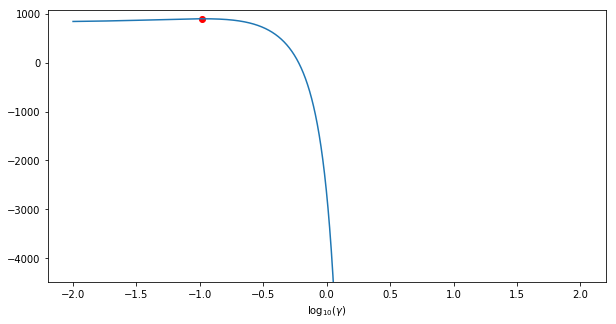

max =  896.2481143914201
log10(gamma) =  -0.98
Оценка максимального правдоподобия: gamma =  0.10471285480508996


In [141]:
find_max(df4)

б) По всей выборке:

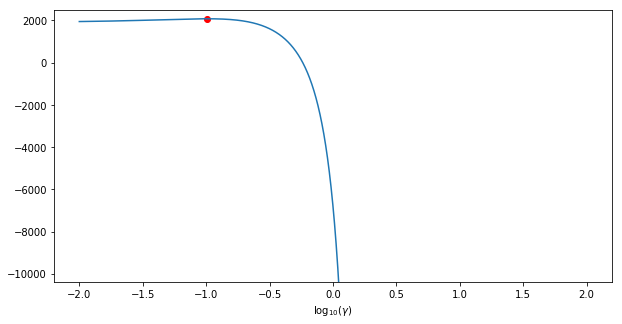

max =  2076.3371414938456
log10(gamma) =  -0.996
Оценка максимального правдоподобия: gamma =  0.10092528860766845


In [142]:
find_max(df)

#### Вывод. 

Полученные значения оценок отличаются, но не сильно. Так что в данном случае, если высокая точность оценки не требуется, можно рассматривать часть выборки, ускоряя вычисления.

В этой выборке большой максимальный элемент (121.04), да и 0.75-квантиль больше единицы. Поэтому при приближении $\log_{10}(\gamma)$ к нулю (а $\gamma$ к 1) и дальнейшем увеличении максимизируемая функция резко падает (ее последнее слагаемое, перед которым стоит минус, растет показательно). 